In Kaggle, add the following to the dependencies:
```
pip install torch
pip install numpy
pip install pydicom
pip install PILlow
pip install matplotlib
```
Enable file persistence and internet access.
Remember that you can run the whole notebook and close the runtime without wasting resources by going to File > Save Version > Save & Run All (Double check that GPU is selected in the advanced settings).
Later, by going to 'File' > 'Version history' you can view the full logs and download the output files.

In [1]:
# Check if running in Kaggle
import os

IN_KAGGLE = False
if os.environ.get("KAGGLE_URL_BASE", ""):
    IN_KAGGLE = True
    !git clone https://github.com/parmigggiana/xai /kaggle/working/xai
    %cd xai
    !git fetch
    !git reset --hard origin/main
    %pip install 'monai[einops,itk,nibabel]>=1.5.0' git+https://github.com/timojl/clipseg.git

In [2]:
# Check if running in Google Colab
IN_COLAB = False
if not IN_KAGGLE:
    try:
        import google.colab
        from google.colab import drive

        IN_COLAB = True
        import os

        drive.mount("/content/drive")
        os.makedirs("/content/drive/MyDrive/xai", exist_ok=True)
        !git clone https://github.com/parmigggiana/xai /content/xai
        %cd /content/xai
        !git fetch
        !git reset --hard origin/main
        %pip install -r requirements.txt
    except Exception:
        pass

In [3]:
from src.datasets.registry import get_dataset
from src.datasets.common import BaseDataset
from pathlib import Path
import json
from src.task_vector import TaskVector
from src.utils import download_and_extract_dataset

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
DATASET_NAMES = ["CHAOS", "MMWHS"]
DOMAINS = ["MR", "CT"]
DATA_PATH = "data/"
CHECKPOINT_PATH = "checkpoints/"
OUTPUTS_PATH = "outputs/"
USE_3D = False
TRAINING_EPOCHS = {
    ("CHAOS", "MR"): 5,
    ("CHAOS", "CT"): 5,
    ("MMWHS", "MR"): 5,
    ("MMWHS", "CT"): 5,
    
    
}
BATCH_SIZE = 8
SPATIAL_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

In [5]:
CHECKPOINT_PATH = Path(CHECKPOINT_PATH)
OUTPUTS_PATH = Path(OUTPUTS_PATH)
DATA_PATH = Path(DATA_PATH)
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUTS_PATH.mkdir(parents=True, exist_ok=True)

if USE_3D:
    encoder_type = "swin_unetr"
else:
    encoder_type = "clipseg"

In [6]:
import torch
from monai import transforms
from monai.data import MetaTensor


def update_metrics(name, new_metrics):
    metrics_file = OUTPUTS_PATH / "metrics.json"

    if not metrics_file.exists():
        metrics = {}
    else:
        with open(metrics_file, "r") as f:
            metrics = json.load(f)

    metrics[name] = new_metrics
    with open(metrics_file, "w") as f:
        json.dump(metrics, f, indent=4)


def debug_metadata(data):
    """Debug transform to print metadata information"""
    print(f"🔍 DEBUG - Data type: {type(data)}")
    if hasattr(data, "meta"):
        print(
            f"🔍 DEBUG - Metadata keys: {list(data.meta.keys()) if data.meta else 'No meta'}"
        )
        print(f"🔍 DEBUG - Full metadata: {data.meta}")
    if hasattr(data, "shape"):
        print(f"🔍 DEBUG - Shape: {data.shape}")
    if hasattr(data, "dtype"):
        print(f"🔍 DEBUG - Dtype: {data.dtype}")
    print("🔍 DEBUG - " + "=" * 50)
    return data



class MetadataAwareTransform:
    """Wrapper to make transforms work with 4-element tuples"""

    def __init__(self, transform):
        self.transform = transform

    def __call__(self, data_tuple):
        if isinstance(data_tuple, tuple) and len(data_tuple) == 4:
            image, label, dict_data, metadata = data_tuple
            
            # Apply transform only to the image
            try:
                if isinstance(metadata, dict):
                    wrapped = MetaTensor(image, meta=metadata)
                else:
                    wrapped = image
                    
                transformed_image = self.transform(wrapped)
                
                # Extract clean metadata if it's a MetaTensor
                if isinstance(transformed_image, MetaTensor):
                    clean_metadata = dict(transformed_image.meta) if transformed_image.meta else {}
                    # Keep only simple, serializable values
                    filtered_metadata = {}
                    for k, v in clean_metadata.items():
                        if isinstance(v, (str, int, float, bool)):
                            filtered_metadata[k] = v
                    return transformed_image, label, dict_data, filtered_metadata
                
                return transformed_image, label, dict_data, metadata
                
            except Exception as e:
                print(f"Error in transform {self.transform}: {e}")
                return image, label, dict_data, metadata
                
        elif isinstance(data_tuple, tuple) and len(data_tuple) == 2:
            # Fallback for 2-element tuples
            data, metadata = data_tuple
            try:
                if isinstance(metadata, dict):
                    wrapped = MetaTensor(data, meta=metadata)
                else:
                    wrapped = data
                out = self.transform(wrapped)
                if isinstance(out, MetaTensor):
                    clean_metadata = dict(out.meta) if out.meta else {}
                    return out, clean_metadata
                return out, metadata
            except Exception as e:
                print(f"Error in transform: {e}")
                return data, metadata
        else:
            # Fallback for non-tuple input
            return self.transform(data_tuple)


class MetadataCompose:
    """Custom Compose that handles 4-element tuples properly"""

    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, *args, **kwargs):
        """Apply transforms sequentially, handling 4-element tuples"""
        if len(args) == 4 and not kwargs:
            # Handle 4-element tuple: (image, label, dict_data, metadata)
            image, label, dict_data, metadata = args
            data_tuple = (image, label, dict_data, metadata)
        elif len(args) == 2 and not kwargs:
            # Handle 2-element tuple: (data, metadata)
            data, metadata = args
            data_tuple = (data, metadata)
        elif len(args) == 1:
            data_tuple = args[0]
        else:
            raise ValueError(f"Unexpected arguments: args={args}, kwargs={kwargs}")

        if isinstance(data_tuple, tuple) and len(data_tuple) == 4:
            image, label, dict_data, metadata = data_tuple

            # Apply each transform sequentially to the image only
            for transform in self.transforms_list:
                if isinstance(transform, MetadataAwareTransform):
                    image, label, dict_data, metadata = transform((image, label, dict_data, metadata))
                else:
                    # For regular transforms, just transform the image
                    image = transform(image)

            return image, label, dict_data, metadata
            
        elif isinstance(data_tuple, tuple) and len(data_tuple) == 2:
            # Handle 2-element tuples
            data, metadata = data_tuple
            for transform in self.transforms_list:
                if isinstance(transform, MetadataAwareTransform):
                    data, metadata = transform((data, metadata))
                else:
                    data = transform(data)
            return data, metadata
            
        else:
            # Fallback for non-tuple input
            result = data_tuple
            for transform in self.transforms_list:
                if isinstance(transform, MetadataAwareTransform):
                    result = transform.transform(result)
                else:
                    result = transform(result)
            return result

    def set_random_state(self, seed=None):
        """Set random state for randomizable transforms"""
        for transform in self.transforms_list:
            if hasattr(transform, "set_random_state"):
                transform.set_random_state(seed=seed)
            elif hasattr(transform, "transform") and hasattr(
                transform.transform, "set_random_state"
            ):
                transform.transform.set_random_state(seed=seed)

def get_preprocessing(dataset_name: str, domain: str, is_training=True):
    """
    Get comprehensive preprocessing pipeline for volumetric medical data.

    Returns separate transforms for images and segmentations to work with ImageDataset.
    Handles different file formats based on dataset:
    - CHAOS: DICOM images (directories), PNG labels (directories)
    - MMWHS: NIfTI images and labels

    Note: Spatial transforms (Spacing, Resize) are handled separately to ensure
    synchronized dimensions between images and labels.
    """
    # Image-specific transforms (applied to image files)

    decode_func = get_decode_func(dataset_name, domain)

    if USE_3D:
        image_transforms = [
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]
    else:
        image_transforms = [
            # transforms.Lambda(lambda x: print(f"Image: {x.shape}") or x),
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            # transforms.Orientation(axcodes="RA"),
        ]

    # Domain-specific intensity normalization for images
    if domain == "CT":
        image_transforms.append(
            transforms.ScaleIntensityRange(
                a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True
            ),
        )
    else:  # MR
        image_transforms.append(
            transforms.NormalizeIntensity(nonzero=True, channel_wise=True),
        )

    # Training-specific augmentations for images only
    if is_training:
        # Image-only augmentations (safe for ImageDataset)
        augmentation_transforms = [
            transforms.RandGaussianNoise(prob=0.2, std=0.05),
            transforms.RandAdjustContrast(prob=0.2, gamma=(0.9, 1.1)),
        ]
        image_transforms.extend(augmentation_transforms)

    if not USE_3D:
        image_transforms.append(transforms.RepeatChannel(repeats=3))

    # Final conversion to tensor for images
    image_transforms.extend(
        [
            transforms.Resize(
                spatial_size=SPATIAL_SIZE,
                size_mode="longest",
                mode="area",
                anti_aliasing=True,
            ),
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    # Segmentation-specific transforms (applied to segmentation files)
    if not USE_3D:
        seg_transforms = [
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(
                channel_dim="no_channel"
            ),  # Ensure channel-first format
            # transforms.Orientation(axcodes="RA"),
        ]
    else:
        seg_transforms = [
            transforms.Lambda(lambda x: print(f": {x.shape}") or x),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]

    seg_transforms.extend(
        [
            transforms.Lambda(lambda x: decode_func(x)),
            transforms.Resize(
                spatial_size=SPATIAL_SIZE, size_mode="longest", mode="nearest"
            ),
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    # Wrap transforms to handle metadata properly
    metadata_aware_image_transforms = [
        MetadataAwareTransform(t) for t in image_transforms
    ]
    metadata_aware_seg_transforms = [MetadataAwareTransform(t) for t in seg_transforms]

    # Create separate transform pipelines that handle metadata
    image_transform = MetadataCompose(metadata_aware_image_transforms)
    seg_transform = MetadataCompose(metadata_aware_seg_transforms)

    return image_transform, seg_transform


def get_decode_func(dataset_name, domain):
    from src.datasets.mmwhs import mmwhs_labels

    decode = None
    if dataset_name == "CHAOS":
        if domain in ["MR", "MRI"]:

            def decode(labels):
                # Convert intensity values to class indices (keep as float32)
                return labels // 63

        elif domain == "CT":

            def decode(labels):
                return torch.where(labels > 0, 1.0, 0.0)

    elif dataset_name == "MMWHS":

        def decode(labels):
            decoded_labels = torch.zeros_like(labels, dtype=torch.float32)
            for i, label_val in enumerate(mmwhs_labels.keys()):
                decoded_labels[labels == label_val] = i
            return decoded_labels

    if decode is None:
        print(
            f"Warning: No decode function defined for {dataset_name} in {domain}. Returning labels unchanged."
        )

        def decode(labels):
            return labels

    return decode

Finetuning on CHAOS dataset in MR domain with 2d images 
Dataset MR total samples: 623
Split sizes - Train: 436, Val: 93, Test: 94

Dataset: CHAOS, Domain: MR
Number of training samples: 436
Number of validation samples: 93
Number of test samples: 94
Image shape: torch.Size([3, 96, 96])
Segmentation shape: torch.Size([1, 96, 96])
Number of classes: 5

Found explicit background class in input. Treating it separately.
Non-background classes: ['Liver', 'Right kidney', 'Left kidney', 'Spleen']
🔄 Loading CLIPSeg weights...
🔧 DEBUG: Initial model parameter check
   Total parameters: 356
   Trainable parameters: 54
   Model device: cpu

Processing CHAOS in MR domain with 2d images
🔧 DEBUG: Before unfreeze()
   Frozen parameters before unfreeze: 302
   Frozen parameters after unfreeze: 0
   Total trainable parameters: 356

🔧 DEBUG: Starting full model finetuning
🚀 Starting training for 5 epochs
   Device: cpu
   Learning Rate: 0.0001
   Weight Decay: 1e-05
   Params: total=150,796,962, trainab

Training:   0%|          | 0/2 [00:00<?, ?it/s]

labels dtype/min/max: torch.float32 0.0 4.0
[DEBUG] Batch 0 - Loss: 0.959856
[DEBUG] Unique labels: [0. 1. 2. 3. 4.]
[DEBUG] Outputs -> mean: -3.189714, std: 4.702722
Unique labels in batch: metatensor([0., 1., 2., 3., 4.])
Unique prediction classes in batch: metatensor([0, 1, 4])


Training: 100%|██████████| 2/2 [01:36<00:00, 48.45s/it, Loss=0.9084]


Epoch 1 - Train Loss: 0.9084
   Param norm deltas (after epoch):
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.586586e+00, after=8.586586e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.bias: Δnorm=+0.000000e+00 (before=1.183554e+00, after=1.183554e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.1.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.633878e+00, after=8.633878e+00)
   Grad non-zero in batches: 2/2 (100.0%)
   Labels seen this epoch: [0, 1, 2, 3, 4]


Validating:   0%|          | 0/1 [00:00<?, ?it/s]

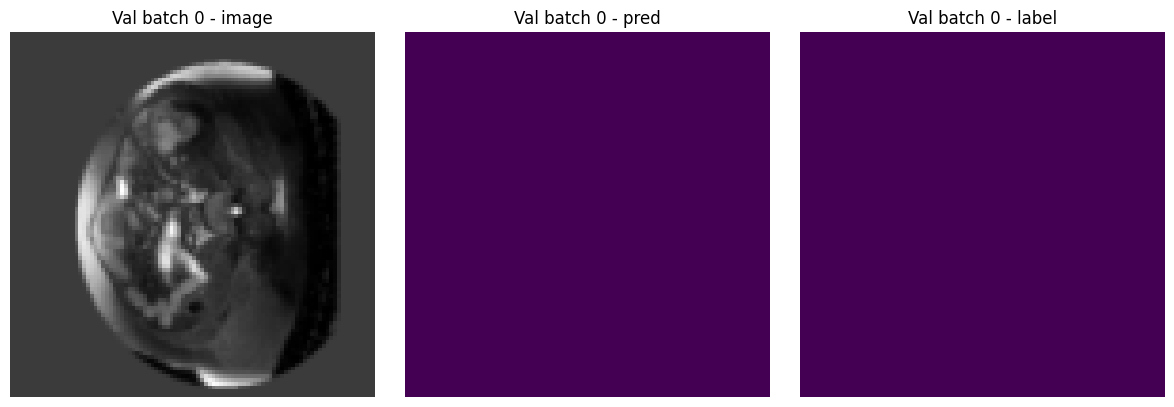

Validating: 100%|██████████| 1/1 [00:18<00:00, 18.73s/it]


Epoch 1 - Val Loss: 0.8235, Val Dice: 0.0049
   ✅ New best Val Dice: 0.0049

📖 Epoch 2/5
   LR(s): 1.000000e-04


Training:   0%|          | 0/2 [00:00<?, ?it/s]

labels dtype/min/max: torch.float32 0.0 4.0
[DEBUG] Batch 0 - Loss: 0.837206
[DEBUG] Unique labels: [0. 1. 2. 3. 4.]
[DEBUG] Outputs -> mean: -2.543712, std: 3.953047
Unique labels in batch: metatensor([0., 1., 2., 3., 4.])
Unique prediction classes in batch: metatensor([0, 1, 2, 4])


Training: 100%|██████████| 2/2 [01:39<00:00, 49.78s/it, Loss=0.8202]


Epoch 2 - Train Loss: 0.8202
   Param norm deltas (after epoch):
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.586586e+00, after=8.586586e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.bias: Δnorm=+0.000000e+00 (before=1.183554e+00, after=1.183554e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.1.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.633878e+00, after=8.633878e+00)
   Grad non-zero in batches: 2/2 (100.0%)
   Labels seen this epoch: [0, 1, 2, 3, 4]


Validating:   0%|          | 0/1 [00:00<?, ?it/s]

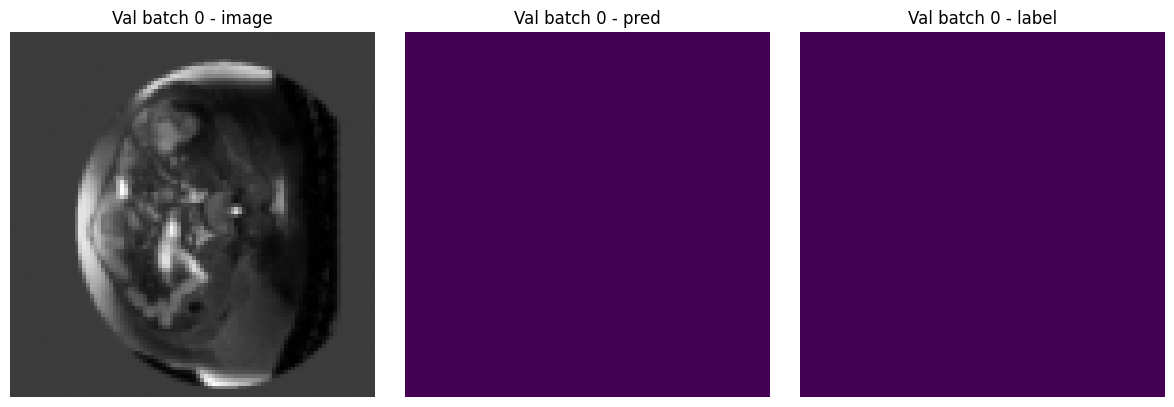

Validating: 100%|██████████| 1/1 [00:21<00:00, 21.09s/it]


Epoch 2 - Val Loss: 0.7503, Val Dice: 0.0439
   ✅ New best Val Dice: 0.0439

📖 Epoch 3/5
   LR(s): 1.000000e-04


Training:   0%|          | 0/2 [00:00<?, ?it/s]

labels dtype/min/max: torch.float32 0.0 4.0
[DEBUG] Batch 0 - Loss: 0.753813
[DEBUG] Unique labels: [0. 1. 2. 3. 4.]
[DEBUG] Outputs -> mean: -1.926387, std: 3.276756
Unique labels in batch: metatensor([0., 1., 2., 3., 4.])
Unique prediction classes in batch: metatensor([0, 1, 2, 3, 4])


Training: 100%|██████████| 2/2 [01:47<00:00, 53.62s/it, Loss=0.7513]


Epoch 3 - Train Loss: 0.7513
   Param norm deltas (after epoch):
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.586586e+00, after=8.586586e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.bias: Δnorm=+0.000000e+00 (before=1.183554e+00, after=1.183554e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.1.attn.out_proj.weight: Δnorm=+0.000000e+00 (before=8.633878e+00, after=8.633878e+00)
   Grad non-zero in batches: 2/2 (100.0%)
   Labels seen this epoch: [0, 1, 2, 3, 4]


Validating:   0%|          | 0/1 [00:00<?, ?it/s]

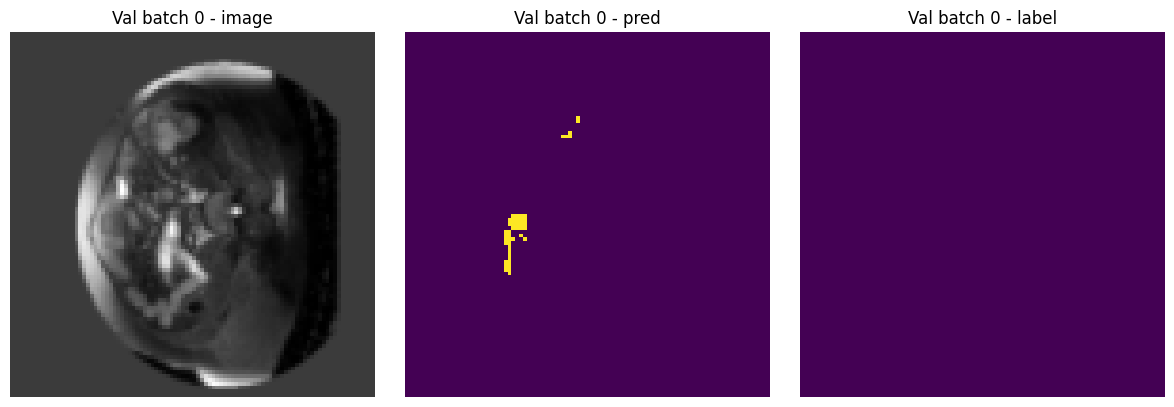

Validating: 100%|██████████| 1/1 [00:21<00:00, 21.60s/it]


Epoch 3 - Val Loss: 0.7144, Val Dice: 0.0697
   ✅ New best Val Dice: 0.0697

📖 Epoch 4/5
   LR(s): 1.000000e-04


Training:   0%|          | 0/2 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [7]:
# Finetuning loop

for (dataset_name, domain), epochs in TRAINING_EPOCHS.items():
    download_and_extract_dataset(dataset_name, DATA_PATH)

    image_transform, seg_transform = get_preprocessing(
        dataset_name, domain, is_training=True
    )

    filename = f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_finetuned.pth"
    filename = CHECKPOINT_PATH / filename
    # Check if the finetuned checkpoint already exists
    if filename.exists():
        print(
            f"Finetuned model for {dataset_name} in {domain} domain with {'3d' if USE_3D else '2d'} images already exists at {filename}. Skipping finetuning."
        )
        continue

    print(
        f"Finetuning on {dataset_name} dataset in {domain} domain with {'3d' if USE_3D else '2d'} images "
    )
    dataset: BaseDataset = get_dataset(
        dataset_name=dataset_name,
        domain=domain,
        transform=image_transform,  # Use transform instead of preprocess
        seg_transform=seg_transform,  # Pass seg_transform too
        base_path=DATA_PATH,
        batch_size=BATCH_SIZE,
        num_workers=0,
        slice_2d=not USE_3D,
    )
    

    #  Ensure the dataset is loaded correctly
    if not isinstance(dataset, BaseDataset):
        raise TypeError(
            f"Expected dataset to be an instance of BaseDataset, got {type(dataset)}"
        )
    # Print dataset information
    print()
    print(f"Dataset: {dataset_name}, Domain: {domain}")
    print(f"Number of training samples: {len(dataset.train_dataset)}")
    print(f"Number of validation samples: {len(dataset.val_dataset)}")
    print(f"Number of test samples: {len(dataset.test_dataset)}")
    print(f"Image shape: {dataset.train_dataset[0][0].shape}")
    print(f"Segmentation shape: {dataset.train_dataset[0][1].shape}")
    print(f"Number of classes: {dataset.num_classes}")
    print()

    model = dataset.get_model(
        encoder_type=encoder_type,
    )

    # 🔧 DEBUG: Check initial model parameters
    print("🔧 DEBUG: Initial model parameter check")
    initial_params = {}
    param_count = 0
    trainable_count = 0
    for name, param in model.named_parameters():
        initial_params[name] = param.clone().detach()
        param_count += 1
        if param.requires_grad:
            trainable_count += 1
    print(f"   Total parameters: {param_count}")
    print(f"   Trainable parameters: {trainable_count}")
    print(f"   Model device: {next(model.parameters()).device}")
    print()

    # Save the baseline model's state_dict before finetuning
    baseline_filename = (
        CHECKPOINT_PATH
        / f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_baseline.pth"
    )
    torch.save(model.encoder, baseline_filename)
    print(
        f"Processing {dataset_name} in {domain} domain with {'3d' if USE_3D else '2d'} images"
    )

    if USE_3D:
        print(
            f"Warning: Using 3D model requires SWIN UNETR, which is not compatible with zero-shot training."
        )
        
        # 🔧 DEBUG: Check freeze_body functionality
        print("🔧 DEBUG: Before freeze_body()")
        frozen_before = sum(1 for p in model.parameters() if not p.requires_grad)
        model.freeze_body()
        frozen_after = sum(1 for p in model.parameters() if not p.requires_grad)
        print(f"   Frozen parameters before: {frozen_before}")
        print(f"   Frozen parameters after: {frozen_after}")
        print(f"   Parameters frozen: {frozen_after - frozen_before}")
        
        # Check which parameters are trainable
        print("   Trainable parameters after freeze_body:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"     {name}: {param.shape}")
        print()
        
        model.finetune(
            epochs=epochs, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

        metrics = model.evaluate()
        update_metrics(
            f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_head",
            metrics,
        )

    # 🔧 DEBUG: Check unfreeze functionality
    print("🔧 DEBUG: Before unfreeze()")
    frozen_before = sum(1 for p in model.parameters() if not p.requires_grad)
    model.unfreeze()
    frozen_after = sum(1 for p in model.parameters() if not p.requires_grad)
    print(f"   Frozen parameters before unfreeze: {frozen_before}")
    print(f"   Frozen parameters after unfreeze: {frozen_after}")
    print(f"   Total trainable parameters: {sum(1 for p in model.parameters() if p.requires_grad)}")
    print()

    # 🔧 DEBUG: Monitor parameter changes during training
    print("🔧 DEBUG: Starting full model finetuning")
    history = model.finetune(
        epochs=epochs,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
    )
    
    # 🔧 DEBUG: Check if parameters actually changed
    print("🔧 DEBUG: Parameter change analysis after finetuning")
    changed_params = 0
    unchanged_params = 0
    max_change = 0.0
    for name, param in model.named_parameters():
        if name in initial_params:
            param_change = (param - initial_params[name]).norm().item()
            if param_change > 1e-8:  # Consider very small changes as unchanged
                changed_params += 1
                max_change = max(max_change, param_change)
            else:
                unchanged_params += 1
                print(f"   Parameter {name} didn't change during training!")
    
    print(f"   Parameters that changed: {changed_params}")
    print(f"   Parameters that didn't change: {unchanged_params}")
    print(f"   Maximum parameter change: {max_change:.6f}")
    
    if changed_params == 0:
        print("   ⚠️ WARNING: No parameters changed during training!")
    elif max_change < 1e-6:
        print(f"   ⚠️ WARNING: Very small parameter changes (max: {max_change:.8f})")
    else:
        print("   ✅ Parameters updated successfully")
    print()

    # 🔧 DEBUG: Check training history
    if history:
        print("🔧 DEBUG: Training history analysis")
        if 'train_loss' in history:
            train_losses = history['train_loss']
            print(f"   Training losses: {train_losses[:5]}...{train_losses[-5:] if len(train_losses) > 5 else train_losses}")
            print(f"   Loss range: {min(train_losses):.6f} - {max(train_losses):.6f}")
            if len(train_losses) > 1:
                loss_change = abs(train_losses[-1] - train_losses[0])
                print(f"   Total loss change: {loss_change:.6f}")
                if loss_change < 1e-6:
                    print("   ⚠️ WARNING: Training loss barely changed!")
        else:
            print("   ⚠️ No 'train_loss' found in history")
        print(f"   History keys: {list(history.keys()) if history else 'None'}")
    else:
        print("🔧 DEBUG: No training history returned")
    print()

    # Save the finetuned model's state_dict
    torch.save(model.encoder, filename)
    model_metrics = model.evaluate()
    update_metrics(
        f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_finetuned",
        model_metrics,
    )
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# Domain adaptation

In [ ]:
# SWIN UNETR Task Vectors
from monai.networks.nets import SwinUNETR
from monai.networks.nets.swin_unetr import SwinTransformer
from monai.networks.blocks.patchembedding import PatchEmbed
from torch.nn.modules.conv import Conv3d
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.container import ModuleList
from monai.networks.nets.swin_unetr import BasicLayer
from monai.networks.nets.swin_unetr import SwinTransformerBlock
from torch.nn.modules.normalization import LayerNorm
from monai.networks.nets.swin_unetr import WindowAttention
from torch.nn.modules.linear import Linear
from torch.nn.modules.activation import Softmax
from torch.nn.modules.linear import Identity
from monai.networks.blocks.mlp import MLPBlock
from torch.nn.modules.activation import GELU
from monai.networks.nets.swin_unetr import PatchMerging
from monai.networks.blocks.unetr_block import UnetrBasicBlock
from monai.networks.blocks.dynunet_block import UnetResBlock
from monai.networks.blocks.convolutions import Convolution
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.instancenorm import InstanceNorm3d
from monai.networks.blocks.unetr_block import UnetrUpBlock
from monai.networks.blocks.dynunet_block import UnetOutBlock
from torch.nn.modules.conv import ConvTranspose3d

safe_globals = [
    SwinUNETR,
    SwinTransformer,
    PatchEmbed,
    Conv3d,
    Dropout,
    ModuleList,
    BasicLayer,
    SwinTransformerBlock,
    LayerNorm,
    WindowAttention,
    Linear,
    Softmax,
    Identity,
    MLPBlock,
    GELU,
    PatchMerging,
    UnetrBasicBlock,
    UnetResBlock,
    Convolution,
    LeakyReLU,
    InstanceNorm3d,
    UnetrUpBlock,
    ConvTranspose3d,
    UnetOutBlock,
]
##

## CLIPSeg Task Vectors
from src.CLIPSeg import CLIPSeg
from clipseg.clipseg import CLIPDensePredT
from clip.model import (
    CLIP,
    VisionTransformer,
    LayerNorm,
    Transformer,
    ResidualAttentionBlock,
    QuickGELU,
)
from torch.nn.modules.conv import Conv2d, ConvTranspose2d
from torch.nn.modules.container import Sequential
from torch.nn.modules.activation import MultiheadAttention, ReLU
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.modules.sparse import Embedding
from torch.nn.modules.transformer import (
    TransformerEncoderLayer,
    TransformerEncoder,
    TransformerDecoderLayer,
    TransformerDecoder,
)
from torch.nn.functional import relu
from torch.nn.modules.container import ModuleDict

safe_globals.extend(
    [
        CLIPSeg,
        CLIPDensePredT,
        CLIP,
        VisionTransformer,
        Conv2d,
        LayerNorm,
        Transformer,
        Sequential,
        ResidualAttentionBlock,
        MultiheadAttention,
        NonDynamicallyQuantizableLinear,
        QuickGELU,
        Embedding,
        ReLU,
        ConvTranspose2d,
        TransformerEncoderLayer,
        TransformerEncoder,
        TransformerDecoderLayer,
        TransformerDecoder,
        relu,
        ModuleDict,
    ]
)

# Build Task Vectors for each dataset and domain
task_vectors = {}
for dataset_name in DATASET_NAMES:
    for domain in DOMAINS:
        print(
            f"Building task vector for {dataset_name} dataset in {domain} domain with {'3d' if USE_3D else '2d'} images"
        )
        baseline_checkpoint = (
            CHECKPOINT_PATH
            / f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_baseline.pth"
        )
        finetuned_checkpoint = (
            CHECKPOINT_PATH
            / f"{dataset_name}_{domain}_{'3d' if USE_3D else '2d'}_finetuned.pth"
        )
        if not baseline_checkpoint.exists():
            print(
                f"Baseline checkpoint for {dataset_name} {domain} does not exist. Skipping task vector creation."
            )
            continue
        if not finetuned_checkpoint.exists():
            print(
                f"Finetuned checkpoint {dataset_name} {domain} does not exist. Skipping task vector creation."
            )
            continue

        with torch.serialization.safe_globals(
            safe_globals=safe_globals,
        ):
            task_vector = TaskVector(baseline_checkpoint, finetuned_checkpoint)
            # Remove keys associated with the output layers from the task vector
            # For swin it's all layers starting with '.out'
            # For clipseg it might not be necessary since the model architecture isn't dependent on the number of output features
            if encoder_type == "swin_unetr":
                for k in task_vector.keys():
                    if k.startswith(".out"):
                        del task_vector[k]
        task_vectors[f"{dataset_name}_{domain}"] = task_vector

In [ ]:
# Build composite task vectors using arithmetic
composite_task_vectors = {
    "MMWHS_CT": task_vectors["MMWHS_MR"]
    + task_vectors["CHAOS_CT"]
    - task_vectors["CHAOS_MR"],
    "MMWHS_MR": task_vectors["MMWHS_CT"]
    + task_vectors["CHAOS_MR"]
    - task_vectors["CHAOS_CT"],
    "CHAOS_CT": task_vectors["CHAOS_MR"]
    + task_vectors["MMWHS_CT"]
    - task_vectors["MMWHS_MR"],
    "CHAOS_MR": task_vectors["CHAOS_CT"]
    + task_vectors["MMWHS_MR"]
    - task_vectors["MMWHS_CT"],
}

In [ ]:
# 🔄 Task Vector Cross-Domain Adaptation Experiments
print("🔄 Task Vector Cross-Domain Adaptation Experiments")
print("=" * 80)

for dataset_name in DATASET_NAMES:
    for target_domain in DOMAINS:
        print(f"\n{dataset_name}: {target_domain} adaptation")

        image_transform, seg_transform = get_preprocessing(
            dataset_name, domain, is_training=False
        )

        dataset_kwargs = {
            "dataset_name": dataset_name,
            "base_path": DATA_PATH,
            "domain": target_domain,
            "transform": image_transform,  # Use transform instead of preprocess
            "seg_transform": seg_transform,  # Pass seg_transform too
            "batch_size": BATCH_SIZE,
            "num_workers": 0,
            "slide_2d": not USE_3D,
        }
        extra_kwargs = {}
        if dataset_name == "CHAOS":
            extra_kwargs["liver_only"] = True

        # try:
        target_dataset = get_dataset(**dataset_kwargs, **extra_kwargs)

        composite_key = f"{dataset_name}_{target_domain}"
        if composite_key in composite_task_vectors:
            composite_task_vector = composite_task_vectors[composite_key]

            target_model = target_dataset.get_model(encoder_type=encoder_type)
            target_model.load_task_vector(composite_task_vector)

            metrics = target_model.evaluate()
            update_metrics(f"{composite_key}_adaptation", metrics)
            print(
                f"   ✅ {composite_key}: Dice={metrics.get('train', {}).get('dice', 0):.3f}"
            )
        else:
            print(f"   ⚠️ No composite task vector found for {composite_key}")

        # except Exception as e:
        #     print(f"   ❌ {dataset_name} {target_domain}: {str(e)[:100]}...")
        #     import traceback
        #     traceback.print_exc()
        #     # continue
        #     break

print("=" * 80)

In [ ]:
# Load and display all metrics
metrics_file = OUTPUTS_PATH / "metrics.json"
if metrics_file.exists():
    with open(metrics_file, "r") as f:
        all_metrics = json.load(f)

    print("\n📊 COMPREHENSIVE RESULTS ANALYSIS")
    print("=" * 80)

    # Baseline performance
    print("\n🏁 Baseline Performance:")
    for key, metrics in all_metrics.items():
        if "baseline" in key:
            dice = metrics.get("train").get("dice", 0)
            hausdorff = metrics.get("train").get("hausdorff", 0)
            print(f"   {key}: Dice={dice:.3f}, HD={hausdorff:.3f}")

    # After Head-training performance
    print("\n🏋️‍♂️ After Head-Training Performance:")
    for key, metrics in all_metrics.items():
        if "head" in key:
            dice = metrics.get("train").get("dice", 0)
            hausdorff = metrics.get("train").get("hausdorff", 0)
            print(f"   {key}: Dice={dice:.3f}, HD={hausdorff:.3f}")

    # Finetuned performance
    print("\n🏆 Finetuned Performance:")
    for key, metrics in all_metrics.items():
        if "finetuned" in key:
            dice = metrics.get("train").get("dice", 0)
            hausdorff = metrics.get("train").get("hausdorff", 0)
            print(f"   {key}: Dice={dice:.3f}, HD={hausdorff:.3f}")

    # Cross-domain adaptation results
    print("\n🔄 Cross-Domain Adaptation Results:")
    for key, metrics in all_metrics.items():
        if "adaptation" in key:
            dice = metrics.get("train").get("dice", 0)
            hausdorff = metrics.get("train").get("hausdorff", 0)
            print(f"   {key}: Dice={dice:.3f}, HD={hausdorff:.3f}")
else:
    print("No metrics file found. Run the experiments first.")

In [ ]:
if IN_COLAB:
    import shutil

    # Copy checkpoints.zip to Google Drive
    !zip -r /content/checkpoints.zip /content/xai/checkpoints
    shutil.copy(
        "/content/checkpoints.zip", "/content/drive/MyDrive/xai/checkpoints.zip"
    )

    # Copy metrics.json to Google Drive
    shutil.copy(
        "/content/xai/outputs/metrics.json", "/content/drive/MyDrive/xai/metrics.json"
    )

In [ ]:
if IN_KAGGLE:
    !zip -r /kaggle/working/checkpoints.zip /kaggle/working/xai/checkpoints